# Imports and Helpers

In [1]:
import networkx as nx
from math import inf
from random import random

In [2]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            dy = vert_gap/(2*len(children))
            vert_offset = 0
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap-vert_offset, xcenter=nextx,
                                    pos=pos, parent = root)
                vert_offset += 0.05
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [3]:
class Partition(frozenset):
    """A class for frozenset with more compact representation."""
    def __repr__(self):
        ret_string = "{"
        for part in self:
            if not isinstance(part, frozenset):
                raise UserWarning("A partition should be a set of sets.")
                ret_string += str(part)
            else:
                for item in part:
                    ret_string += str(item)
                    ret_string += ","
                ret_string = ret_string[:-1]
                ret_string += "|"
        if len(ret_string) > 1:
            ret_string = ret_string[:-1]
        ret_string += "}"
        return ret_string
    
    def is_crossed_by(self, u,v):
        """
        Checks to see if the partition is crossed by the link uv. 
        That is, u and v are in two different parts of the partition.
        """
        whole = set()
        for part in self:
            whole |= part
        return ((u in whole) and (v in whole)) and not any(set(u,v) <= part for part in self)

# Algorithm

In [4]:
def greedyNC_TAP(G):
    """
        Uses the greedy algorithm of [1]_ to get an approximate solution to the
        NC-TAP problem.
        
        Parameters
        ----------
        
        
        Returns
        -------
        F : set
            The set of links that comprise the solution.
        
        wgt : dict
            A dictionary where the keys are partitions and the values are
            the weights assigned to those partitions by the algorithm.
            Note that, as shown in [1]_, wgt is a scaled down solution to the
            dual problem.
            
        References
        ----------
        .. [1] Grout, Logan, Joseph Cheriyan, and Bundit Laekhanukit. "On a Partition LP Relaxation for Min-Cost 2-Node Connected Spanning Subgraphs." arXiv preprint arXiv:2111.07481 (2021).
        """
    # Verify data and extract fundamental structures (T, L, etc.)
    assert nx.is_weighted(G)
    assert not nx.is_negatively_weighted(G)
    cost = nx.get_edge_attributes(G, "weight")
    T = nx.minimum_spanning_tree(G)
    assert sum(cost[e] for e in T.edges()) == 0
    
    L = nx.difference(G, T).edges()
    nonLeaves = set(T.nodes())
    for v in T.nodes():
        if T.degree(v) <= 1:
            nonLeaves.remove(v)
    
    # Initialize algorithm
    F = set()
    wgt = dict()
    currentPartition = dict()
    for u in nonLeaves:
        copy = T.copy()
        copy.remove_node(u)
        currentPartition[u] = Partition(frozenset(C) 
                                        for C in nx.connected_components(copy))
        
    inc = dict()
    for (u,v) in L:
        path = nx.shortest_path(T, u, v)
        path.remove(u)
        path.remove(v)
        inc[(u,v)] = set(path)
    
    iteration=0
    # Main Loop
    while(any(len(currentPartition[u]) > 1 for u in nonLeaves)):
        iteration += 1
        print("Iteration {}:".format(iteration))
        for u in nonLeaves:
            print("\t Current P_{}: {}".format(u, currentPartition[u]))
        # Find the link with minimum "average cost"
        bestLink = None
        minAvgCost = inf
        for link in L:
            if len(inc[link]) == 0:
                avgCost = inf
            else:
                avgCost = cost[link]/len(inc[link])
                print("\t Ratio for {} is {}".format(link, avgCost))
            if avgCost < minAvgCost:
                minAvgCost = avgCost
                bestLink = link
        
        # Update
        F.add(bestLink)
        T.add_edge(*bestLink)
        L -= {bestLink}
        print("\t Choose link {}".format(bestLink))
        for u in inc[bestLink]:
            print("\t\t update wgt(currentPartition[{}]={}".format(u, minAvgCost))
            wgt[currentPartition[u]] = minAvgCost
            copy = T.copy()
            copy.remove_node(u)
            currentPartition[u] = Partition(Partition(C) 
                                        for C in nx.connected_components(copy))
            print("\t\t update currentPartition[{}]={}".format(u, currentPartition[u]))
        
        for l in L:
            inc_l = set(inc[l])
            for u in inc_l:
                if any([(set(l) <= C) for C in currentPartition[u]]):
                    inc[l].remove(u)
            
    return F, wgt

# Custom Class

In [5]:
class NC_TAP_Instance():
    """
    A class used to contain all info about an instance of the
    Node-Connectivity Tree Augmentation Problem (NC-TAP) and to draw them nicely
    
    ...
    
    Attributes
    ----------
    G : undirected graph
        The full graph of the NC-TAP instance including tree edges, links, and
        edge-costs as networkx edge attributes.
        
    T : undirected graph
        The subgraph of G which is a spanning tree. This is what needs to be
        augmented to be 2-node-connected.
    
    L : set
        The edges of G that are not in T, called links.
        
    Methods
    -------
    add_tree_edge(u,v)
        Adds an edge to both G and T.
        
    add_link(u,v,cost=1)
        Adds a link to both G and L.
    
    draw(soln={})
        Draws the NC-TAP instance.
        
    greedy_solve()
        Uses a greedy algorithm to get an approximate solution to the
        NC-TAP problem.
    """
    def __init__(self, G=None):
        """
        Initialize an instance of NC-TAP
        
        Parameters
        ----------
        G : nx.Graph
            An undirected graph that defines the NC-TAP instance
        """
        if G is None:
            G = nx.Graph()
        else:
            assert nx.is_weighted(G), "Link costs must be non-negative"
            assert not nx.is_negatively_weighted(G), "Link costs must be non-negative"
        self.G = G.copy()
        self.T = nx.minimum_spanning_tree(self.G)
        assert sum(self.T[u][v]['weight'] for u,v in self.T.edges()) == 0
        self.L = set(nx.difference(self.G, self.T).edges())
        for u,v in self.T.edges():
            self.G[u][v]['color'] = 'black'
        for u,v in self.L:
            self.G[u][v]['color'] = 'black'
        
        # Private attributes used for drawing the instance
        self._last_root = None
        self._pos = None
            
    def add_tree_edge(self, u, v):
        """
        Adds the tree edge uv to both G and T with weight 0
        
        Parameters
        ----------
        u, v 
            Endpoints of the edge to be added
        """
        self.G.add_edge(u, v, weight=0, color="black")
        self.T.add_edge(u, v, weight=0, color="black")
        
    def add_link(self, u, v, cost=1):
        """
        Adds the link uv to both G and L with weight equal to the given cost
        
        Parameters
        ----------
        u, v 
            Endpoints of the edge to be added
        cost : int
            Non-negative integer representing the cost of the link. (Default=1)
        """
        assert cost > 0, "Link costs must be non-negative"
        self.G.add_edge(u, v, weight=cost, color="blue")
        self.L.add((u, v))
        
    def draw(self, soln={}, root=None):
        """
        Draw the instance with a hierarchal tree-structure, rooted at the given node.
        Tree edges are given in black,
        links are either red (if they are in soln) or blue (if not)
        
        Parameters
        ----------
        soln : set 
            A set of links to be drawn in red.
        root
            A node in G to be used as the root of the drawing.
        """
        width = [10/(10+self.G[u][v]['weight']) for u,v in self.G.edges()]
        color = nx.get_edge_attributes(self.G, 'color')
        for u,v in soln:
            color[(u,v)] = "red"
            
        if self._last_root != root:
            self._pos = hierarchy_pos(self.T, root)  
        try:
            nx.draw(self.G, self._pos, edge_color=color.values(), width=width, with_labels=True)
        except nx.NetworkXError:
            self._pos = hierarchy_pos(self.T, root)
            nx.draw(self.G, self._pos, edge_color=color.values(), width=width, with_labels=True)
            
    def greedy_solve(self):
        """
        Uses the greedy algorithm of [1]_ to get an approximate solution to the
        NC-TAP problem.
        
        Returns
        -------
        F : set
            The set of links that comprise the solution.
        
        wgt : dict
            A dictionary where the keys are partitions and the values are
            the weights assigned to those partitions by the algorithm.
            Note that, as shown in [1]_, wgt is a scaled down solution to the
            dual problem.
            
        References
        ----------
        .. [1] Grout, Logan, Joseph Cheriyan, and Bundit Laekhanukit. "On a Partition LP Relaxation for Min-Cost 2-Node Connected Spanning Subgraphs." arXiv preprint arXiv:2111.07481 (2021).
        """
        return greedyNC_TAP(self.G)

# Examples

## K_4

Iteration 1:
	 Current P_0: {3|2|1}
	 Ratio for (1, 2) is 1.0
	 Ratio for (1, 3) is 1.0
	 Ratio for (2, 3) is 1.0
	 Choose link (1, 2)
		 update wgt(currentPartition[0]=1.0
		 update currentPartition[0]={3|1,2}
Iteration 2:
	 Current P_0: {3|1,2}
	 Ratio for (2, 3) is 1.0
	 Ratio for (1, 3) is 1.0
	 Choose link (2, 3)
		 update wgt(currentPartition[0]=1.0
		 update currentPartition[0]={1,2,3}

{(2, 3), (1, 2)}
{{3|2|1}: 1.0, {3|1,2}: 1.0}

Iteration 1:
	 Current P_0: {3|2|1}
	 Ratio for (1, 2) is 1.0
	 Ratio for (1, 3) is 1.0
	 Ratio for (2, 3) is 1.0
	 Choose link (1, 2)
		 update wgt(currentPartition[0]=1.0
		 update currentPartition[0]={3|1,2}
Iteration 2:
	 Current P_0: {3|1,2}
	 Ratio for (2, 3) is 1.0
	 Ratio for (1, 3) is 1.0
	 Choose link (2, 3)
		 update wgt(currentPartition[0]=1.0
		 update currentPartition[0]={1,2,3}

{(2, 3), (1, 2)}
{{3|2|1}: 1.0, {3|1,2}: 1.0}


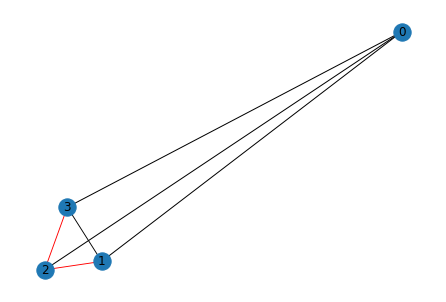

In [6]:
K4 = nx.Graph()
K4.add_edge(0, 1, weight=0)
K4.add_edge(0, 2, weight=0)
K4.add_edge(0, 3, weight=0)
K4.add_edge(1, 2, weight=1)
K4.add_edge(2, 3, weight=1)
K4.add_edge(3, 1, weight=1)

F, wgt = greedyNC_TAP(K4)
print()
print(F)
print(wgt)
print()
K4 = NC_TAP_Instance(K4)
F, wgt = K4.greedy_solve()
print()
print(F)
print(wgt)
K4.draw(F)

## Tightness of Analysis Example

Iteration 1:
	 Current P_2: {1|3,4,5}
	 Current P_3: {4,5|1,2}
	 Current P_4: {1,2,3|5}
	 Ratio for (1, 3) is 1.0
	 Ratio for (1, 5) is 0.33666666666666667
	 Ratio for (2, 4) is 0.5
	 Ratio for (3, 5) is 0.3333333333333333
	 Choose link (3, 5)
		 update wgt(currentPartition[4]=0.3333333333333333
		 update currentPartition[4]={1,2,3,5}
Iteration 2:
	 Current P_2: {1|3,4,5}
	 Current P_3: {4,5|1,2}
	 Current P_4: {1,2,3,5}
	 Ratio for (2, 4) is 0.5
	 Ratio for (1, 3) is 1.0
	 Ratio for (1, 5) is 0.505
	 Choose link (2, 4)
		 update wgt(currentPartition[3]=0.5
		 update currentPartition[3]={1,2,4,5}
Iteration 3:
	 Current P_2: {1|3,4,5}
	 Current P_3: {1,2,4,5}
	 Current P_4: {1,2,3,5}
	 Ratio for (1, 3) is 1.0
	 Ratio for (1, 5) is 1.01
	 Choose link (1, 3)
		 update wgt(currentPartition[2]=1.0
		 update currentPartition[2]={1,3,4,5}

{(2, 4), (1, 3), (3, 5)}
{{1,2,3|5}: 0.3333333333333333, {4,5|1,2}: 0.5, {1|3,4,5}: 1.0}


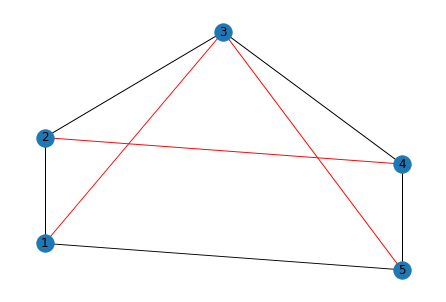

In [7]:
fig1 = nx.Graph()
fig1.add_edge(1, 2, weight=0)
fig1.add_edge(2, 3, weight=0)
fig1.add_edge(3, 4, weight=0)
fig1.add_edge(4, 5, weight=0)

fig1.add_edge(1, 3, weight=1)
fig1.add_edge(2, 4, weight=1/2)
fig1.add_edge(3, 5, weight=1/3)
fig1.add_edge(1, 5, weight=1.01)

fig1 = NC_TAP_Instance(fig1)

F, wgt = fig1.greedy_solve()
print()
print(F)
print(wgt)

fig1.draw(F, 3)

## Based on Tree with nodes of degree 3 and 4

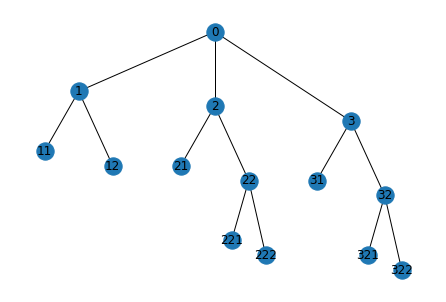

In [8]:
tree = nx.Graph()

tree.add_edge(0, 1, weight=0, color="black")
tree.add_edge(0, 2, weight=0, color="black")
tree.add_edge(0, 3, weight=0, color="black")

tree.add_edge(1, 11, weight=0, color="black")
tree.add_edge(1, 12, weight=0, color="black")

tree.add_edge(2, 21, weight=0, color="black")
tree.add_edge(2, 22, weight=0, color="black")

tree.add_edge(22, 221, weight=0, color="black")
tree.add_edge(22, 222, weight=0, color="black")

tree.add_edge(3, 31, weight=0, color="black")
tree.add_edge(3, 32, weight=0, color="black")

tree.add_edge(32, 321, weight=0, color="black")
tree.add_edge(32, 322, weight=0, color="black")

pos = hierarchy_pos(tree, 0)
nx.draw(tree, pos, with_labels=True)

### Example with \lambda=2 (all links cover 2 tree edges)

In [9]:
exLinkLen2 = tree.copy()
digits = 2

# root to level 2
exLinkLen2.add_edge(0, 11, weight=round(random(), digits), color='blue')
exLinkLen2.add_edge(0, 12, weight=round(random(), digits), color='blue')
exLinkLen2.add_edge(0, 21, weight=round(random(), digits), color='blue')
exLinkLen2.add_edge(0, 22, weight=round(random(), digits), color='blue')
exLinkLen2.add_edge(0, 31, weight=round(random(), digits), color='blue')
exLinkLen2.add_edge(0, 32, weight=round(random(), digits), color='blue')

# level 1 to level 3
exLinkLen2.add_edge(2, 221, weight=round(random(), digits), color='blue')
exLinkLen2.add_edge(2, 222, weight=round(random(), digits), color='blue')
exLinkLen2.add_edge(3, 321, weight=round(random(), digits), color='blue')
exLinkLen2.add_edge(3, 322, weight=round(random(), digits), color='blue')

# level 1 to level 1
exLinkLen2.add_edge(1, 2, weight=round(random(), digits), color='blue')
exLinkLen2.add_edge(1, 3, weight=round(random(), digits), color='blue')
exLinkLen2.add_edge(2, 3, weight=round(random(), digits), color='blue')

# level 2 to level 2
exLinkLen2.add_edge(11, 12, weight=round(random(), digits), color='blue')
exLinkLen2.add_edge(21, 22, weight=round(random(), digits), color='blue')
exLinkLen2.add_edge(31, 32, weight=round(random(), digits), color='blue')

# level 3 to level 3
exLinkLen2.add_edge(221, 222, weight=round(random(), digits), color='blue')
exLinkLen2.add_edge(321, 322, weight=round(random(), digits), color='blue')

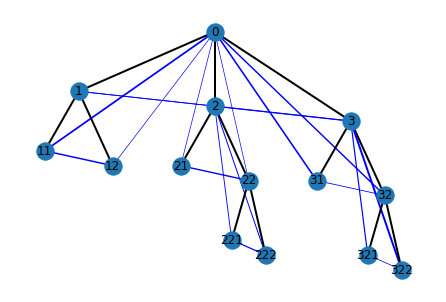

In [10]:
nx.draw(exLinkLen2, pos, 
        edge_color=nx.get_edge_attributes(exLinkLen2, 'color').values(),
        width=[2/(1+2*exLinkLen2[u][v]['weight']) for u,v in exLinkLen2.edges()],
        with_labels=True)

Iteration 1:
	 Current P_0: {1,11,12|32,321,322,3,31|2,21,22,221,222}
	 Current P_1: {0,32,2,3,321,322,21,22,221,222,31|11|12}
	 Current P_2: {0,1,32,3,321,322,11,12,31|222,221,22|21}
	 Current P_3: {31|0,1,2,11,12,21,22,221,222|32,321,322}
	 Current P_32: {321|322|0,1,2,3,11,12,21,22,221,222,31}
	 Current P_22: {221|222|0,1,2,3,32,321,322,11,12,21,31}
	 Ratio for (0, 11) is 0.07
	 Ratio for (0, 12) is 0.98
	 Ratio for (0, 21) is 0.99
	 Ratio for (0, 22) is 0.99
	 Ratio for (0, 31) is 0.13
	 Ratio for (0, 32) is 0.2
	 Ratio for (1, 2) is 0.61
	 Ratio for (1, 3) is 0.75
	 Ratio for (2, 221) is 0.64
	 Ratio for (2, 222) is 0.5
	 Ratio for (2, 3) is 0.27
	 Ratio for (3, 321) is 0.35
	 Ratio for (3, 322) is 0.01
	 Ratio for (11, 12) is 0.18
	 Ratio for (21, 22) is 0.22
	 Ratio for (221, 222) is 0.32
	 Ratio for (31, 32) is 0.76
	 Ratio for (321, 322) is 0.87
	 Choose link (3, 322)
		 update wgt(currentPartition[32]=0.01
		 update currentPartition[32]={0,1,2,3,322,11,12,21,22,221,222,31|321

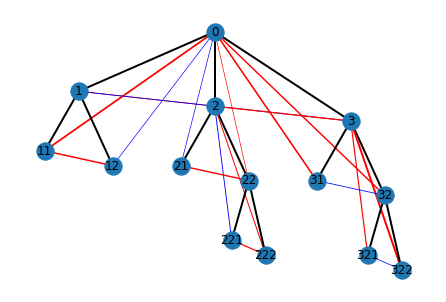

In [11]:
F, wgt = greedyNC_TAP(exLinkLen2)
print()
print(F)
print(wgt)

for u,v in F:
    exLinkLen2[u][v]['color']="red"

nx.draw(exLinkLen2, pos, 
        edge_color=nx.get_edge_attributes(exLinkLen2, 'color').values(),
        width=[2/(1+2*exLinkLen2[u][v]['weight']) for u,v in exLinkLen2.edges()],
        with_labels=True)

## Jan 2 Example

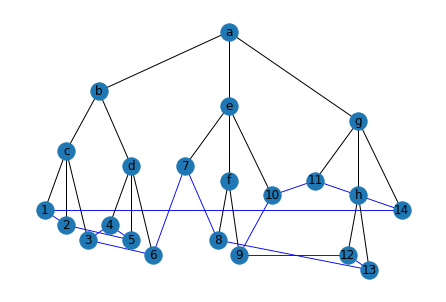

In [12]:
example = NC_TAP_Instance()

# Tree edges
example.add_tree_edge('a','b')
example.add_tree_edge('b','c')
example.add_tree_edge('c',1)
example.add_tree_edge('c',2)
example.add_tree_edge('c',3)
example.add_tree_edge('b','d')
example.add_tree_edge('d',4)
example.add_tree_edge('d',5)
example.add_tree_edge('d',6)
example.add_tree_edge('a','e')
example.add_tree_edge('e',7)
example.add_tree_edge('e','f')
example.add_tree_edge('f',8)
example.add_tree_edge('f',9)
example.add_tree_edge('e',10)
example.add_tree_edge('a','g')
example.add_tree_edge('g',11)
example.add_tree_edge('g','h')
example.add_tree_edge('h',12)
example.add_tree_edge('h',13)
example.add_tree_edge('g',14)

# Links
example.add_link(1,2)
example.add_link(2,5)
example.add_link(5,4)
example.add_link(4,3)
example.add_link(3,6)
example.add_link(6,7)
example.add_link(7,8)
example.add_link(8,13)
example.add_link(13,12)
example.add_link(12,9)
example.add_link(9,10)
example.add_link(10,11)
example.add_link(11,14)
example.add_link(14,1)

example.draw(root='a')

Iteration 1:
	 Current P_e: {f,8,9|10|1,2,3,4,5,6,11,12,13,14,h,b,a,c,d,g|7}
	 Current P_b: {d,4,5,6|e,a,7,8,9,10,11,12,13,14,h,f,g|3,1,2,c}
	 Current P_c: {3|2|e,4,5,6,7,8,9,10,11,12,13,14,h,b,a,d,f,g|1}
	 Current P_d: {5|6|4|e,1,2,3,7,8,9,10,11,12,13,14,h,b,a,c,f,g}
	 Current P_f: {9|e,1,2,3,4,5,6,7,10,11,12,13,14,h,b,c,a,d,g|8}
	 Current P_g: {12,13,h|e,1,2,3,4,5,6,7,8,9,10,b,a,c,d,f|11|14}
	 Current P_h: {e,1,2,3,4,5,6,7,8,9,10,11,14,b,c,a,d,f,g|12|13}
	 Current P_a: {1,2,c,3,4,5,6,d,b|e,f,7,8,9,10|g,11,12,13,14,h}
	 Ratio for (1, 2) is 1.0
	 Ratio for (1, 14) is 0.25
	 Ratio for (2, 5) is 0.3333333333333333
	 Ratio for (3, 4) is 0.3333333333333333
	 Ratio for (3, 6) is 0.3333333333333333
	 Ratio for (4, 5) is 1.0
	 Ratio for (6, 7) is 0.25
	 Ratio for (7, 8) is 0.5
	 Ratio for (8, 13) is 0.2
	 Ratio for (9, 12) is 0.2
	 Ratio for (9, 10) is 0.5
	 Ratio for (10, 11) is 0.3333333333333333
	 Ratio for (11, 14) is 1.0
	 Ratio for (12, 13) is 1.0
	 Choose link (8, 13)
		 update wgt(cur

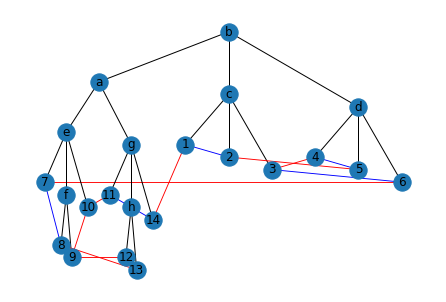

In [13]:
F,wgt = example.greedy_solve()
print()
print(F)
print()
print(wgt)
print()
example.draw(F,'b')

Iteration 1:
	 Current P_e: {f,8,9|10|1,2,3,4,5,6,11,12,13,14,h,b,a,c,d,g|7}
	 Current P_b: {d,4,5,6|e,a,7,8,9,10,11,12,13,14,h,f,g|3,1,2,c}
	 Current P_c: {3|2|e,4,5,6,7,8,9,10,11,12,13,14,h,b,a,d,f,g|1}
	 Current P_d: {5|6|4|e,1,2,3,7,8,9,10,11,12,13,14,h,b,a,c,f,g}
	 Current P_f: {9|e,1,2,3,4,5,6,7,10,11,12,13,14,h,b,c,a,d,g|8}
	 Current P_g: {12,13,h|e,1,2,3,4,5,6,7,8,9,10,b,a,c,d,f|11|14}
	 Current P_h: {e,1,2,3,4,5,6,7,8,9,10,11,14,b,c,a,d,f,g|12|13}
	 Current P_a: {1,2,c,3,4,5,6,d,b|e,f,7,8,9,10|g,11,12,13,14,h}
	 Ratio for (1, 2) is 1.0
	 Ratio for (1, 14) is 3.0
	 Ratio for (2, 5) is 3.0
	 Ratio for (3, 4) is 3.0
	 Ratio for (3, 6) is 3.0
	 Ratio for (4, 5) is 1.0
	 Ratio for (6, 7) is 3.0
	 Ratio for (7, 8) is 1.5
	 Ratio for (8, 13) is 3.0
	 Ratio for (9, 12) is 3.0
	 Ratio for (9, 10) is 1.5
	 Ratio for (10, 11) is 3.0
	 Ratio for (11, 14) is 1.0
	 Ratio for (12, 13) is 1.0
	 Choose link (1, 2)
		 update wgt(currentPartition[c]=1.0
		 update currentPartition[c]={3|e,4,5,6,7

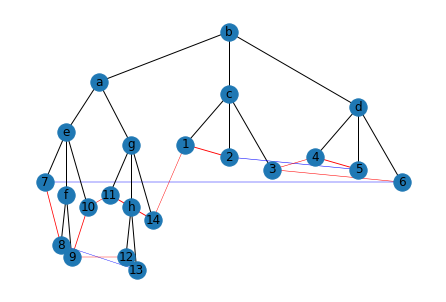

In [14]:
for u, v in example.L:
    linkLength = len(nx.shortest_path(example.T, u, v))-1
    if linkLength == 3:
        example.G[u][v]['weight'] = 3
    elif linkLength == 4:
        example.G[u][v]['weight'] = 9
    elif linkLength == 5:
        example.G[u][v]['weight'] = 12
    elif linkLength == 6:
        example.G[u][v]['weight'] = 15
    
F,wgt = example.greedy_solve()
print()
print(F)
print()
print(wgt)
print()
example.draw(F,'b')

In [15]:
import gurobipy as gp
def exact_IP_solve(instance):
    ip = gp.Model("NC-TAP IP")
    x = {(u,v): ip.addVar(obj=instance.G[u][v]['weight'], 
                            vtype=gp.GRB.BINARY, 
                            name="x_({},{})".format(u,v)) 
           for u,v in instance.L}
    for u in filter(lambda v:instance.T.degree(u) > 1, instance.T.nodes()):
        copy = instance.T.copy()
        copy.remove_node(u)
        P = Partition(frozenset(C) for C in nx.connected_components(copy))
        ip.addConstr(sum([x[(u,v)] for u,v in instance.L if P.is_crossed_by(u,v)] >= 1, "Constr_{}".format(u)))
        
    ip.update()
    ip.solve()
    
    assert all([x[(u,v)].X == 1 for u,v in instance.T.edges()])
    F = set(filter(lambda u,v : x[(u,v)].X == 1, instance.L))
    return F

In [16]:
OPT = exact_IP_solve(example)
print(OPT)
example.draw(OPT)

Set parameter Username


GurobiError: License expired 2022-11-06